## 1. Estimation of the Banana distribution

In this notebook, we will show how we can estimate a density $\pi$ given a limited number of samples $\boldsymbol{x}^i \sim \pi \in \mathbb{R}^{N_x}$. We rely on the adaptive estimation framework developed in Baptista et al. [1].

References: 

[1] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[2] Marzouk, Y., Moselhy, T., Parno, M., & Spantini, A. (2016). Sampling via measure transport: An introduction. Handbook of uncertainty quantification, 1-41.

In [1]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions

Load some packages to make nice figures

In [2]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)

using LaTeXStrings

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


### Problem setup

 We start by generating $N_e$ samples from a banana distribution.

In [3]:
Ne = 500 # Number of samples
Nx = 2 # Dimension of the state

# Define the parameters of the banana distribution
μ = 0.0
σ = 2.0
bananicity = 0.3

# Generate the samples
X = sample_banana(Ne, μ = μ, σ = σ, bananicity = bananicity)

alpine overwritten
aquamarine overwritten
army overwritten
atlantic overwritten
auerbach overwritten
aurora overwritten
autumn overwritten
avocado overwritten
beach overwritten
blackbody overwritten
bluegreenyellow overwritten
bosch_garden overwritten
bosch_hell overwritten
botticelli overwritten
brass overwritten
browncyan overwritten
canaletto overwritten
candy overwritten
cezanne overwritten
cherry overwritten
cmyk overwritten
coffee overwritten
cubehelix overwritten
darkrainbow overwritten
darkterrain overwritten
deepsea overwritten
fall overwritten
fruitpunch overwritten
fuchsia overwritten
grays1 overwritten
grayyellow overwritten
greenbrownterrain overwritten
greenpink overwritten
hokusai overwritten
holbein overwritten
island overwritten
jet overwritten
klimt overwritten
lake overwritten
leonardo overwritten
lighttemperaturemap overwritten
lightterrain overwritten
mint overwritten
munch overwritten
neon overwritten
pastel overwritten
pearl overwritten
picasso overwritten
pigeon

2×500 Matrix{Float64}:
 -2.22425   -2.60088   -0.361909    2.75491  …  -3.21921  2.92845  1.73031
  0.501274   0.339485  -0.0971219  -0.34988      2.05007  2.25435  0.124677

`X` is an ensemble matrix whose columns are the different ensemble members, i.e. $\boldsymbol{X} = 
\left[ \boldsymbol{x}^1, \ldots, \boldsymbol{x}^{N_e} \right]  \in \mathbb{R}^{N_x \times N_e}$.

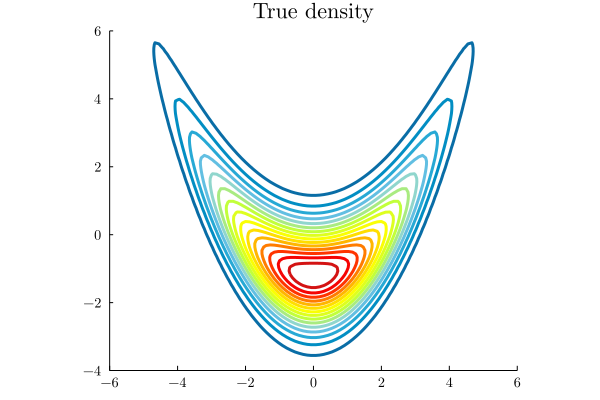

In [4]:
Nlog = 100
logbanana = zeros(Nlog, Nlog)

xrange = range(-6.0; stop = 6.0, length = Nlog)
yrange = range(-4.0; stop = 6.0, length = Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y]; μ = μ, σ = σ, bananicity = bananicity)
    end
end


contour(xrange, yrange, exp.(logbanana)', ratio = 1,
         title = "True density",
         colorbar = false, grid = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

We define an object `S` of  type`HermiteMap`to hold the Knothe-Rosenblatt rearrangement that pushes forward $\pi$ to the reference density, i.e. the standard Gaussian distribution $\rho$.
The default constructor for an `HermiteMap` requires, where $m$ is the maximal order of the Hermite polynomials considered in the expansion, $N_x$ the dimension of the state, $L$ a linear transformation that rescale the samples to get zero mean and unitary standard deviation component-wise, and $C$ an array of $N_x$ `MapComponent`.

In [45]:
m = 30
S = HermiteMap(m, X; diag = true, b = "CstProHermiteBasis");

The next step is to use the greedy algorithm developed by Baptista et al. (2020) to construct a sparse expansion of the different components of the map $S$. Several kind of optimization are implemented 
depending on the desired robustness of the Knothe-Rosenblatt rearrangement:
* `kfold` uses a k-fold cross validation procedure (the more robust choice)
* `split` splits the set of samples into a training and a testing
* An `Int64` to determine the maximum number of features for each component $s^k$ of the map $S$
* `nothing` to simply optimize the existing coefficients in the basis expansion

In [46]:
@time optimize(S, X, "kfold"; withqr = true)

 13.565921 seconds (6.00 M allocations: 32.740 GiB, 7.86% gc time, 0.32% compilation time)


Hermite map of dimension 2:
Hermite map component of dimension 1 with Nψ = 1 active features
Hermite map component of dimension 2 with Nψ = 14 active features


The map $S$ is an approximation of the pushforward of the target density $\pi$, to the standard Gaussian density $\rho$.

We can access the different components of the map $S$ as follows:

In [47]:
S[1]

Hermite map component of dimension 1 with Nψ = 1 active features


In [48]:
S[2]

Hermite map component of dimension 2 with Nψ = 14 active features


We can access the coefficients of the expansion for each map component with `getcoeff`.

In [49]:
getcoeff(S[2])

14-element Vector{Float64}:
  12.312019625300547
 -13.666808992808168
   3.939915368600603
  -7.81372000273736
  -0.11174714702801265
   2.993891844119392
  -3.9692306373288764
  -0.478317734858948
   0.09043390950864591
  -4.303772084469854
   0.9871394119020529
   0.15034193221842745
  -1.9846422866055802
  -0.9169135495466394

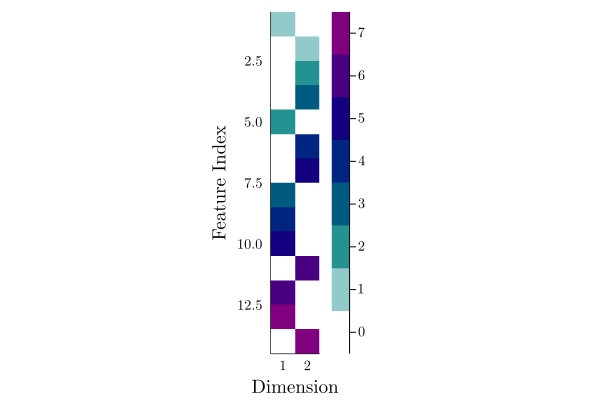

In [50]:
plot(S[2].I.f)

`getidx` can be used to obtain the active features of the different map components. The number of columns is the number of dimensions. Each line correspond to a multi-index for the different components 

In [51]:
getidx(S[1])

1×1 Matrix{Int64}:
 1

Using `PlotRecipes.jl`, we plot the number of occurences of each variable (*columns*) in each map component (*rows*).

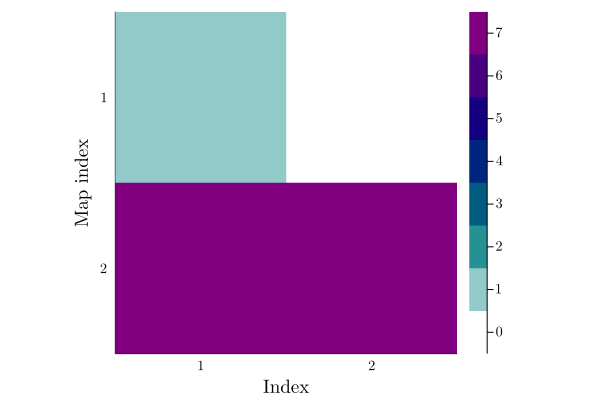

In [52]:
plot(S)

By setting `degree = true`, we plot maximum multi-index of the features identified for each variable (*columns*) in each map component (*rows*)

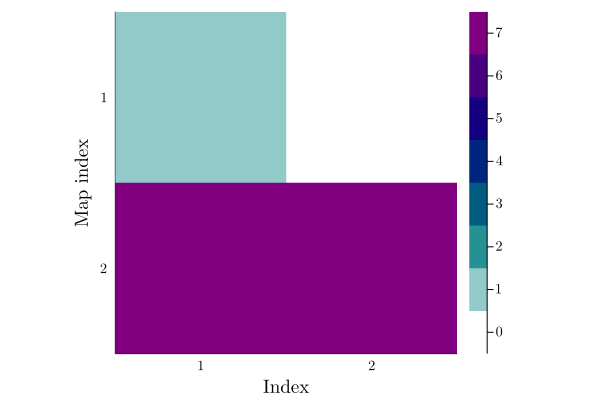

In [53]:
plot(S; degree = true)

  We can now compare the log-density of the true Banana density with the approximated one.

Let's create a grid and evaluate the logpdf the densities

In [54]:
logbanana_approx = zeros(Nlog, Nlog)
lognormal = zeros(Nlog, Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana_approx[i,j] = log_pdf(S, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

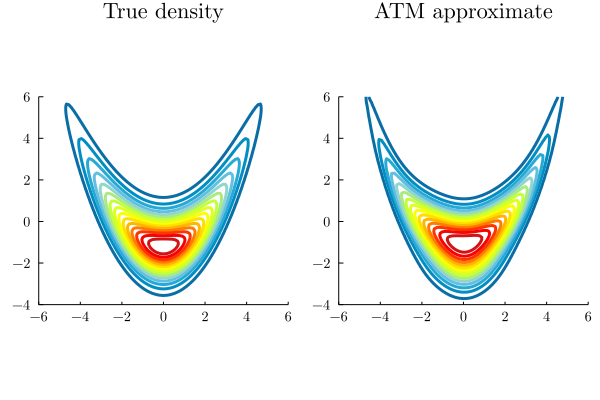

In [55]:
plt = plot(layout = grid(1, 2), colorbar = false, grid = false)
contour!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1,
         title = "True density",
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

contour!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1,
         title = "ATM approximate",
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

We can overlap the estimated density with the samples

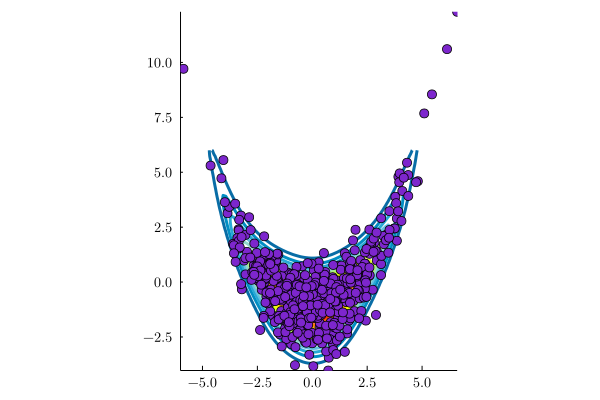

In [56]:
contour(xrange, yrange, exp.(logbanana_approx)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(X[1,:], X[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 5)

By definition, the map $S$ pushes forward the samples $\boldsymbol{x}^i$ to the standard normal distribution $\rho$ of $\mathbb{R}^2$, denoted $\boldsymbol{S}_{\sharp} \pi = \rho$,  i.e. $\boldsymbol{x}^i \sim \pi \Rightarrow{} \boldsymbol{S}(\boldsymbol{x}^i) \sim \rho$

In [57]:
SpushX = evaluate(S, X)

2×500 Matrix{Float64}:
 -1.17011   -1.36457   -0.208621   1.40054  …  -1.6838    1.49014  0.871559
  0.384149  -0.342571   1.05724   -1.4841       0.443978  1.20724  0.451873

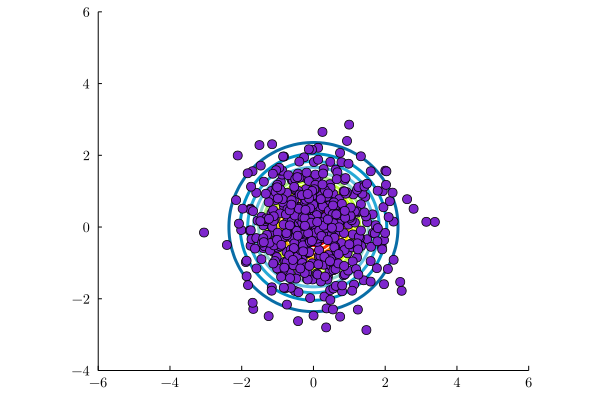

In [58]:
contour(xrange, yrange, exp.(lognormal)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(SpushX[1,:], SpushX[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 5)

We can compute the statistics of the pushed samples

In [59]:
mean(SpushX; dims = 2)[:,1] # close to zero

2-element Vector{Float64}:
 4.0190073491430665e-17
 5.7257285424381244e-5

In [60]:
cov(SpushX; dims = 2) # close to the identity matrix 

2×2 Matrix{Float64}:
 1.0          0.000828711
 0.000828711  0.996367

We can use the map $\boldsymbol{S}$ to generate new samples from the target density $\pi$. The map $\boldsymbol{S}$ pulls back  samples $\boldsymbol{z}^i$ of the standard normal distribution $\rho$ to the target density $\pi$, denoted $\boldsymbol{S}^{\sharp} \rho = \pi$, i.e. $\boldsymbol{z}^i \sim \rho \Rightarrow{} \boldsymbol{S}^{-1}(\boldsymbol{z}^i) \sim \pi$.

In [61]:
Znew = randn(Nx, Ne)
Xnew = zeros(Nx, Ne);

We use the in-place routine `inverse` to solve the triangular system $\boldsymbol{S}(\boldsymbol{x}^i) = \boldsymbol{z}^i$ for $\boldsymbol{x}^i \in \mathbb{R}^{N_x}$ for the different samples. From the lower triangular structure of $\boldsymbol{S}$, this inversion reduces to a sequence of one dimensional root finding problems Marzouk et al. [2].

In [62]:
inverse!(Xnew, copy(Znew), S)

2×500 Matrix{Float64}:
  0.0815606  3.65527  -1.36004  -0.448675  …   0.465265  -0.104973  -0.616499
 -0.583521   2.7204   -1.34681  -1.51031      -0.750869  -1.02393   -0.968364

In [63]:
evaluate(S, Xnew)-Znew

2×500 Matrix{Float64}:
 3.46945e-18  0.0          0.0          …  0.0          0.0
 2.22045e-16  1.23165e-16  1.11022e-16     1.94289e-16  7.91034e-16

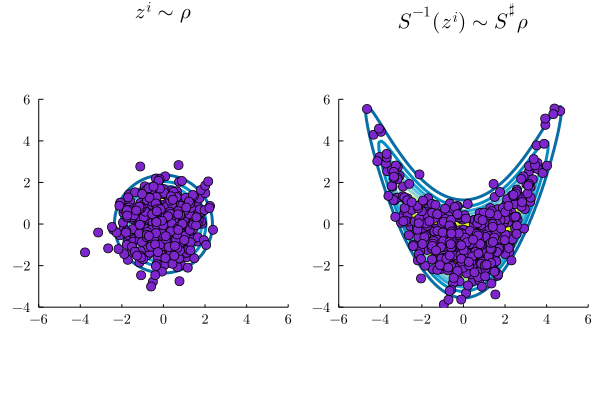

In [64]:
plt = plot(layout = grid(1, 2))

contour!(plt[1,1], xrange, yrange, exp.(lognormal)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (yrange[1], yrange[end]), linewidth = 3)
scatter!(plt[1,1], Znew[1,:], Znew[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 5, 
         title = L"z^i \sim \rho")

contour!(plt[1,2], xrange, yrange, exp.(logbanana)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (yrange[1], yrange[end]), linewidth = 3)
scatter!(plt[1,2], Xnew[1,:], Xnew[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 5,
            title = L"S^{-1}(z^i) \sim S^{\sharp}\rho")